# 3. Multi-class Vnet on BV

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 3.1 Setup Torch Global Variable, load memory map 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 2
NUM_WORKERS = 6
NUM_TRAIN = 80
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [3]:
#-------------------------LOAD THE DATA SET-------------------------------------------#
regen = False

if regen:

    data_index = np.arange(107)
    data_index = np.delete(data_index, 46)
    data_idnex = np.random.shuffle(data_index)
else:
    data_index = np.array ([50,17,81,39,36,88,33,77,7,1,52,43,34,40,41,18,72,58,51,
                  63,78,35,16,79,0,89,70,67,60,13,76,8,2,47,4,97,29,85,32,
                  55,30,49,44,11,101,22,37,10,92,68,5,64,105,95,20,38,99,
                  84,86,91,96,71,98,104,45,69,103,27,19,59,73,106,93,24,80,
                  66,28,90,3,102,31,26,94,62,54,48,12,61,87,42,65,74,53,57,
                  14,56,83,100,25,6,75,82,23,9,21,15])


dataset_trans = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(1),
                             RandomFilp(0.5),
                             RandomAffine(180, 10)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([2, 1, 192, 256, 256]) torch.Size([2, 3, 192, 256, 256])
1 torch.Size([2, 1, 192, 256, 256]) torch.Size([2, 3, 192, 256, 256])
2 torch.Size([2, 1, 192, 256, 256]) torch.Size([2, 3, 192, 256, 256])
3 torch.Size([2, 1, 192, 256, 256]) torch.Size([2, 3, 192, 256, 256])


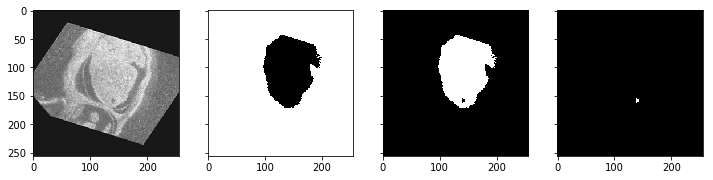

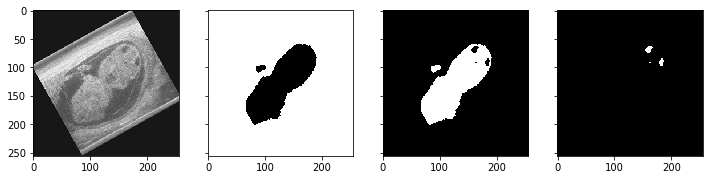

In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE)
        break

In [5]:
from vnet import DVNet

#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

LoadCKP = False
CKPPath = 'checkpoint2019-03-31 13:33:50.772063.pth'

model = DVNet(classnum=3)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=30, verbose=True)

if LoadCKP:
    model, optimizer, scheduler = loadckp(model, optimizer, scheduler, CKPPath, device=device)

In [6]:
from loss import *

train(model, train_loader, validation_loader, optimizer, scheduler, \
      device=device, dtype=dtype,lossFun=dice_loss_2, epochs=500)

PATH = 'Vet_currculum_404.pth'
torch.save(model.state_dict(), PATH)


RuntimeError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 15.90 GiB total capacity; 14.82 GiB already allocated; 429.81 MiB free; 2.81 MiB cached)

In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'Vet_currculum_330.pth'
torch.save(model.state_dict(), PATH)

## Checking the result

* load model dict from *.pth state dict
* show low res image slice
* save image to file

In [ ]:
from training import check_img

ifCPK = True

PATH = 'checkpoint2019-04-02 19_31_19.246479.pth'

model = VNet(classnum=3, slim=False)

if ifCPK:
    model.load_state_dict(torch.load(PATH)['state_dict'])
    pass
else:
    model.load_state_dict(torch.load(PATH))
    
model = model.to(device=device)

In [ ]:
data_index = np.array ([50,17,81,39,36,88,33,77,7,1,52,43,34,40,41,18,72,58,51,
              63,78,35,16,79,0,89,70,67,60,13,76,8,2,47,4,97,29,85,32,
              55,30,49,44,11,101,22,37,10,92,68,5,64,105,95,20,38,99,
              84,86,91,96,71,98,104,45,69,103,27,19,59,73,106,93,24,80,
              66,28,90,3,102,31,26,94,62,54,48,12,61,87,42,65,74,53,57,
              14,56,83,100,25,6,75,82,23,9,21,15])

data_index = data_index[80:]

dataset_test = niiDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(2),
                         ])
                     )

validation_loader = DataLoader(dataset_test, batch_size=1)

from loss import *

check_img(model, validation_loader, device, dtype, cirrculum=2, lossFun=dice_loss_2, data_index=data_index)